# Data Pre-processing
This notebook takes you through some introductory techniques for data processing in preperation for machine learning.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Configure display of dataframe visualizations
pd.options.display.mpl_style = 'default'

# Read in data and cleanse if needed

In [ ]:
train_df = pd.read_csv("train.csv")

In [ ]:
test_df = pd.read_csv("test.csv")

In [ ]:
# Columns to be used for now...
ml_columns = [
    "Pclass",
    "Age",
    "SibSp",
    "Parch",
    "Fare"
]

In [ ]:
# Drop rows with NaN for now...
train_df = train_df.dropna(subset=ml_columns)
# Select columns for analysis
train_df = train_df[ml_columns + ['Survived']]
train_df_features = train_df[ml_columns]
train_df_features

# Look at the correlation of attributes
What does the correlation tell us?

In [ ]:
# Plot heat map of variable correlation
plt.clf()
plt.imshow(train_df.corr(), cmap='hot', interpolation='nearest')
plt.xlabel(",".join(train_df.columns.values))
plt.ylabel(",".join(train_df.columns.values[::-1]))
plt.show()
train_df.corr()

# Describe the data

In [ ]:
train_df_features.describe()

# Visualize data

Visualizing the data can give you insight as to the distribution of the data that you are working with.

For a list of types of distributions: http://people.stern.nyu.edu/adamodar/New_Home_Page/StatFile/statdistns.htm


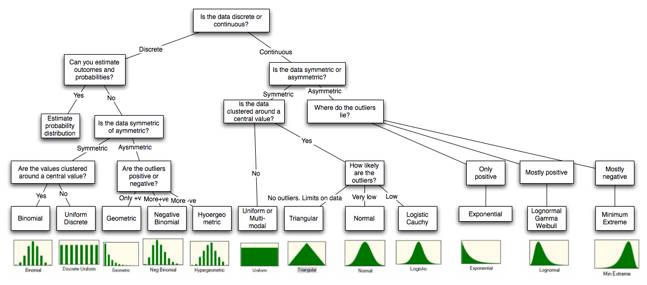

Graphs made from: https://machinelearningmastery.com/quick-and-dirty-data-analysis-with-pandas/

In [ ]:
train_df_features.boxplot()

In [ ]:
train_df_features.hist()

In [ ]:
# Visualize Target class distributions
train_df.groupby('Survived').hist()

## Now maybe you want to compare the classes of two features

In [ ]:
train_df.groupby('Survived')["Age"].hist(alpha=.4)

In [ ]:
train_df.groupby('Survived')["Pclass"].hist(alpha=.4)

In [ ]:
train_df.groupby('Survived')["Parch"].hist(alpha=.4)

# Skew and Kurtosis of Distributions
Knowing the skew and kritosis of your feature distributions can help inform decisions on apply data transformation techniques.

Definitions from: http://www.itl.nist.gov/div898/handbook/eda/section3/eda35b.htm

In [ ]:
skew_df = pd.DataFrame([])
kurtosis_df = pd.DataFrame([])
data_sets = {"Original": train_df_features}

In [ ]:
# Get skewness of data
"""
Skewness is a measure of symmetry, or more precisely, the lack of symmetry. 
A distribution, or data set, is symmetric if it looks the same to the left 
and right of the center point.
"""
# The data is left skewed when below 0 and right skewed above 0, a normal distribution has 0 skew
skew_df["skew_basic"] = train_df_features.skew()
skew_df

In [ ]:
# Get kurtosis of data
"""
Kurtosis is a measure of whether the data are heavy-tailed or light-tailed 
relative to a normal distribution. That is, data sets with high kurtosis 
tend to have heavy tails, or outliers. Data sets with low kurtosis tend to 
have light tails, or lack of outliers. A uniform distribution would be the 
extreme case.
"""
# Kurtosis of normal distribution is 0 (in the pandas function case)
kurtosis_df["kurosis_basic"] = train_df_features.kurtosis()
kurtosis_df

## Well how about we normalize our data...
"Normalizing" the data may seem like a useful thing to do... but lets see for ourselves.

In [ ]:
train_df_features_normalized = (train_df_features - train_df_features.mean())/train_df_features.std()
data_sets["Normalized"] = train_df_features_normalized

In [ ]:
skew_df['skew_normalized'] = train_df_features_normalized.skew()
skew_df

In [ ]:
kurtosis_df['kurtosis_normalized'] = train_df_features_normalized.kurtosis()
kurtosis_df

### Conclusion
From this we can see that normalizing the data did nothing for us, which makes sense as this normalization only reduces the range of values and not the distribution.

## Lets apply some methods to deal with skew and kurtosis

### Logged normal

In [ ]:
# To deal with right skewness we can take the log of the values
import math
logged_df = train_df_features.applymap(lambda x: math.log(float(x)+1)) # Add one to avoid division by 0 error
data_sets["Log Transformed"] = logged_df

In [ ]:
skew_df["skew_logged"] = logged_df.skew()
skew_df

In [ ]:
kurtosis_df["kurtosis_logged"] = logged_df.kurtosis()
kurtosis_df

### Conclusion
We see that the values which were previously very right skewed become less skewed, but left scewed values take a hit.

### Rooted Normal

In [ ]:
rooted_df = train_df_features.applymap(lambda x: math.sqrt(abs(x))*x/abs(x) if x != 0 else 0 ) # Add one to avoid division by 0 error
data_sets["Root Transformed"] = rooted_df

In [ ]:
skew_df["skew_rooted"] = rooted_df.skew()
skew_df

In [ ]:
kurtosis_df["kurtosis_rooted"] = rooted_df.kurtosis()
kurtosis_df

# Now lets see how the different data sets do

In [ ]:
# Split into train and test
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
X = train_df_features
y = train_df['Survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=43)

In [ ]:
def train_test(model_in, data):
    return cross_val_score(model_in(), data, y).mean()
    model = model_in()
    model.fit(data.drop(X_test.index).sort_index(), y_train.sort_index())
    return model.score(data.drop(X_train.index).sort_index(), y_test.sort_index())

In [ ]:
def test_data_sets(model_in):
    print("Data set: Accuracy")
    for name, data in data_sets.items():
        print("{0}: {1}".format(name, train_test(model_in, data)))

## Gaussian

In [ ]:
print("Gaussian Naive Bayes")
test_data_sets(GaussianNB)

## Logisitic Regression

In [ ]:
print("Logistic Regression")
test_data_sets(LogisticRegression)

# Now lets mix and match columns for the distribution sets

In [ ]:
best_skewed_df = pd.DataFrame([])
best_kurt_df = pd.DataFrame([])

In [ ]:
train_df_features.columns.values

In [ ]:
skew_df

In [ ]:
kurtosis_df

In [ ]:
# Select the columns which had the best skew (close to 0)
best_skewed_df['Pclass'] = data_sets["Original"]['Pclass']
best_skewed_df['Age'] = data_sets["Original"]['Age']
best_skewed_df['SibSp'] = data_sets["Root Transformed"]['SibSp']
best_skewed_df['Parch'] = data_sets["Root Transformed"]['Parch']
best_skewed_df['Fare'] = data_sets["Log Transformed"]['Fare']

In [ ]:
# Select the columns which had the best kurtosis (close to 0)
best_kurt_df['Pclass'] = data_sets["Log Transformed"]['Pclass']
best_kurt_df['Age'] = data_sets["Original"]['Age']
best_kurt_df['SibSp'] = data_sets["Root Transformed"]['SibSp']
best_kurt_df['Parch'] = data_sets["Root Transformed"]['Parch']
best_kurt_df['Fare'] = data_sets["Log Transformed"]['Fare']

### Best skewed

In [ ]:
print("Gaussian Naive Bayes")
print(train_test(GaussianNB, best_skewed_df))

In [ ]:
print("Logistic Regression")
print(train_test(LogisticRegression, best_skewed_df))

### Best kurtosis

In [ ]:
print("Gaussian Naive Bayes")
print(train_test(GaussianNB, best_kurt_df))

In [ ]:
print("Logistic Regression")
print(train_test(LogisticRegression, best_kurt_df))

## Challenge 1: Using the insights about our data's distribution, try binning the data and compare results

In [ ]:
# TODO: Bin values, then see if the score improves
# Your code here